# Simulated read check plots

Here I am working on making plots to validate and display the characteristics of the simulated reads and chromosomes generated by the random side of the pipeline.

In [1]:
import pandas as pd
from Bio import SeqIO
from pathlib import Path

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R

library(ggplot2)
library(RColorBrewer)
library(ggpubr)

Read in simulated records table.

In [4]:
records = pd.read_csv('../../output/simulated/substrates/recordTable.tsv', sep='\t')

Read chromosome sequences

In [5]:
chromosome_dir = Path('../../output/simulated/substrates/chrs')
chrs = []
for fasta in chromosome_dir.iterdir():
    if fasta.suffix == '.fa':
        chrs.append(SeqIO.read(str(fasta), 'fasta'))

In [6]:
len(chrs)

60

## Average C occurance over each type of chromosome

In [68]:
def sliding_windower(record, window_size=10, step=2):
    sliding_dict = []
    i = 0
    while i < len(record) - window_size:
        s, e = i, i+window_size
        window = record.seq[s:e]
        c_count = window.count('C')
        c_prop = c_count / window_size
        sliding_dict.append(
            {
                'id': record.id.split('-')[0],
                'name': record.description,
                'window': i,
                'window_size': window_size,
                'c_count': c_count,
                'c_prop': c_prop
            }
        )
        i += step
    return pd.DataFrame(sliding_dict)

Calculate sliding window C content for all chromosomes.

In [69]:
sliding_c = pd.concat([sliding_windower(r) for r in chrs])
len(sliding_c)

104700

In [70]:
%%R -i sliding_c

agg.mean <- aggregate(sliding_c[, c('c_count', 'c_prop')], list(sliding_c$id, sliding_c$window, sliding_c$name), mean)
colnames(agg.mean) <- c('id', 'window', 'name', 'mean_c_count', 'mean_c_prop')

agg.sd <- aggregate(sliding_c[, c('c_count', 'c_prop')], list(sliding_c$id, sliding_c$window, sliding_c$name), sd)
colnames(agg.sd) <- c('id', 'window', 'name', 'sd_c_count', 'sd_c_prop')

agg <- merge(agg.mean, agg.sd, by=c('id', 'window', 'name'))

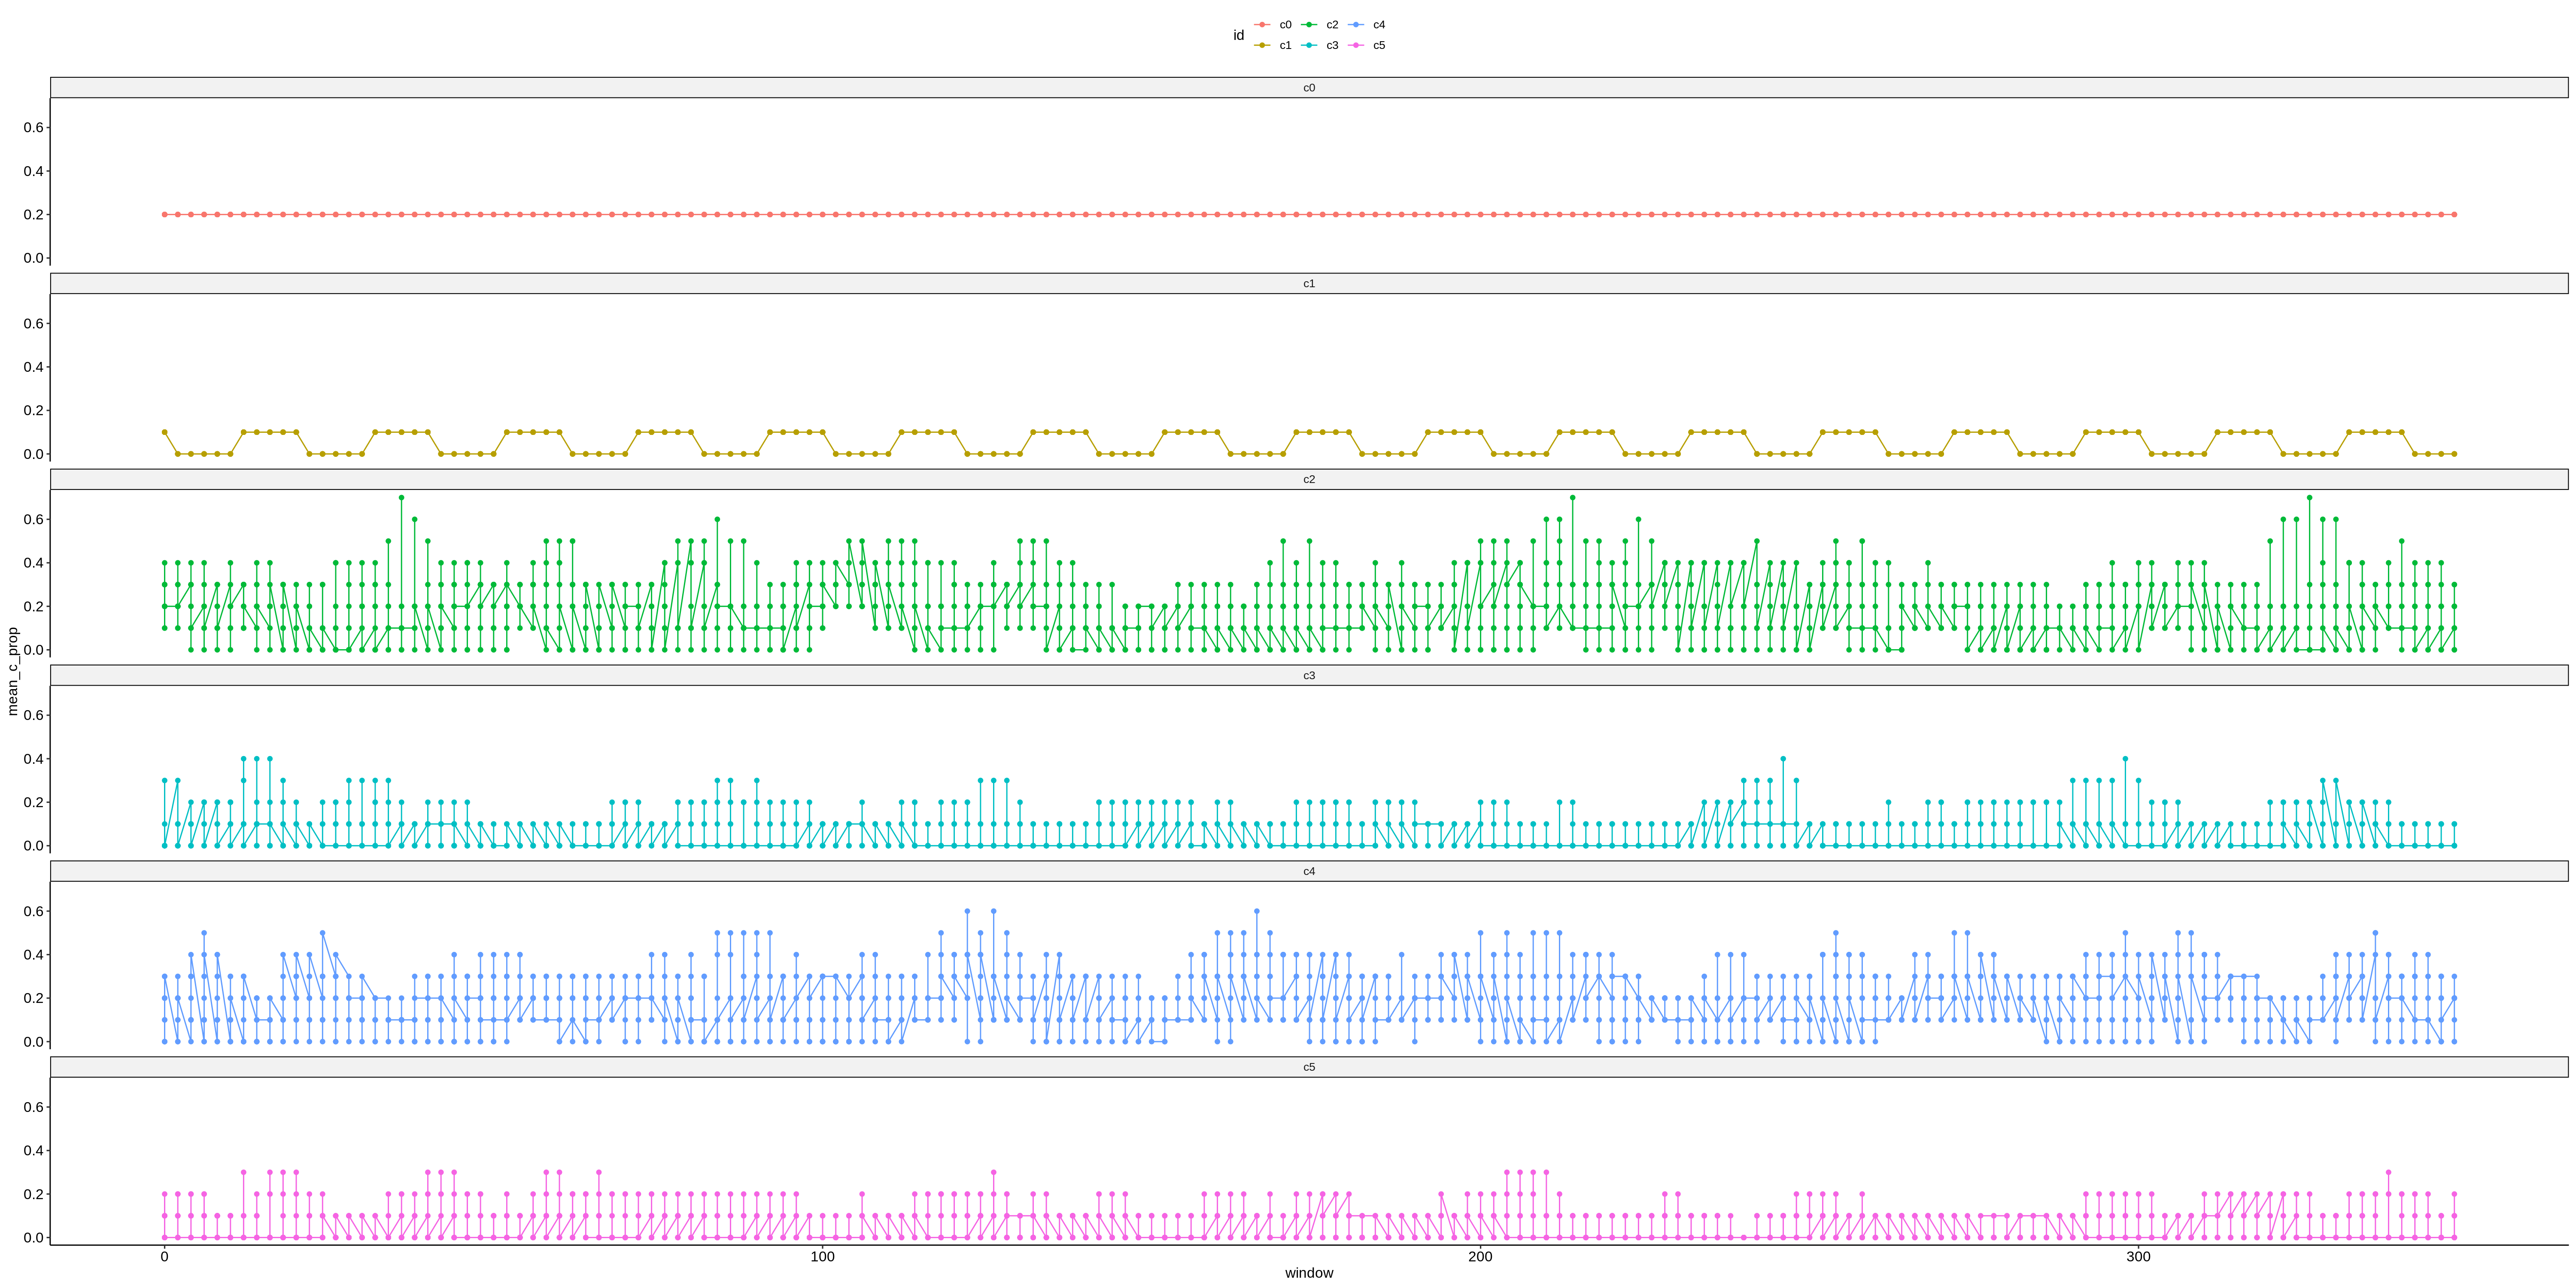

In [74]:
%%R -w 30 -h 15 --units in -r 200

max.window <- max(agg$window)
agg.half <- subset(agg, window < max.window/10)

ggplot(agg.half, aes(x=window, y=mean_c_prop, color=id)) + geom_line() + geom_point() + facet_wrap(~id, nrow=6, ncol=1) + theme_pubr()

## Average Distance to closest C

In [87]:
def closest_c(record):
    c_distances = []
    for each_base in record.seq:
        if each_base == 'C':
            d = 0
            while True:
                left, right = d-1, d+1
                if left > 0 and record.seq[left] == 'C':
                    break
                if right < len(record.seq)-1 and record.seq[right] == 'C':
                    break
                d += 1
            c_dist = {
                'id': record.id.split('-')[0],
                'name': record.description,
                'closest_c': d
            }
            c_distances.append(c_dist)
    return pd.DataFrame(c_distances)

In [88]:
closest_c_df = pd.concat([closest_c(r) for r in chrs])

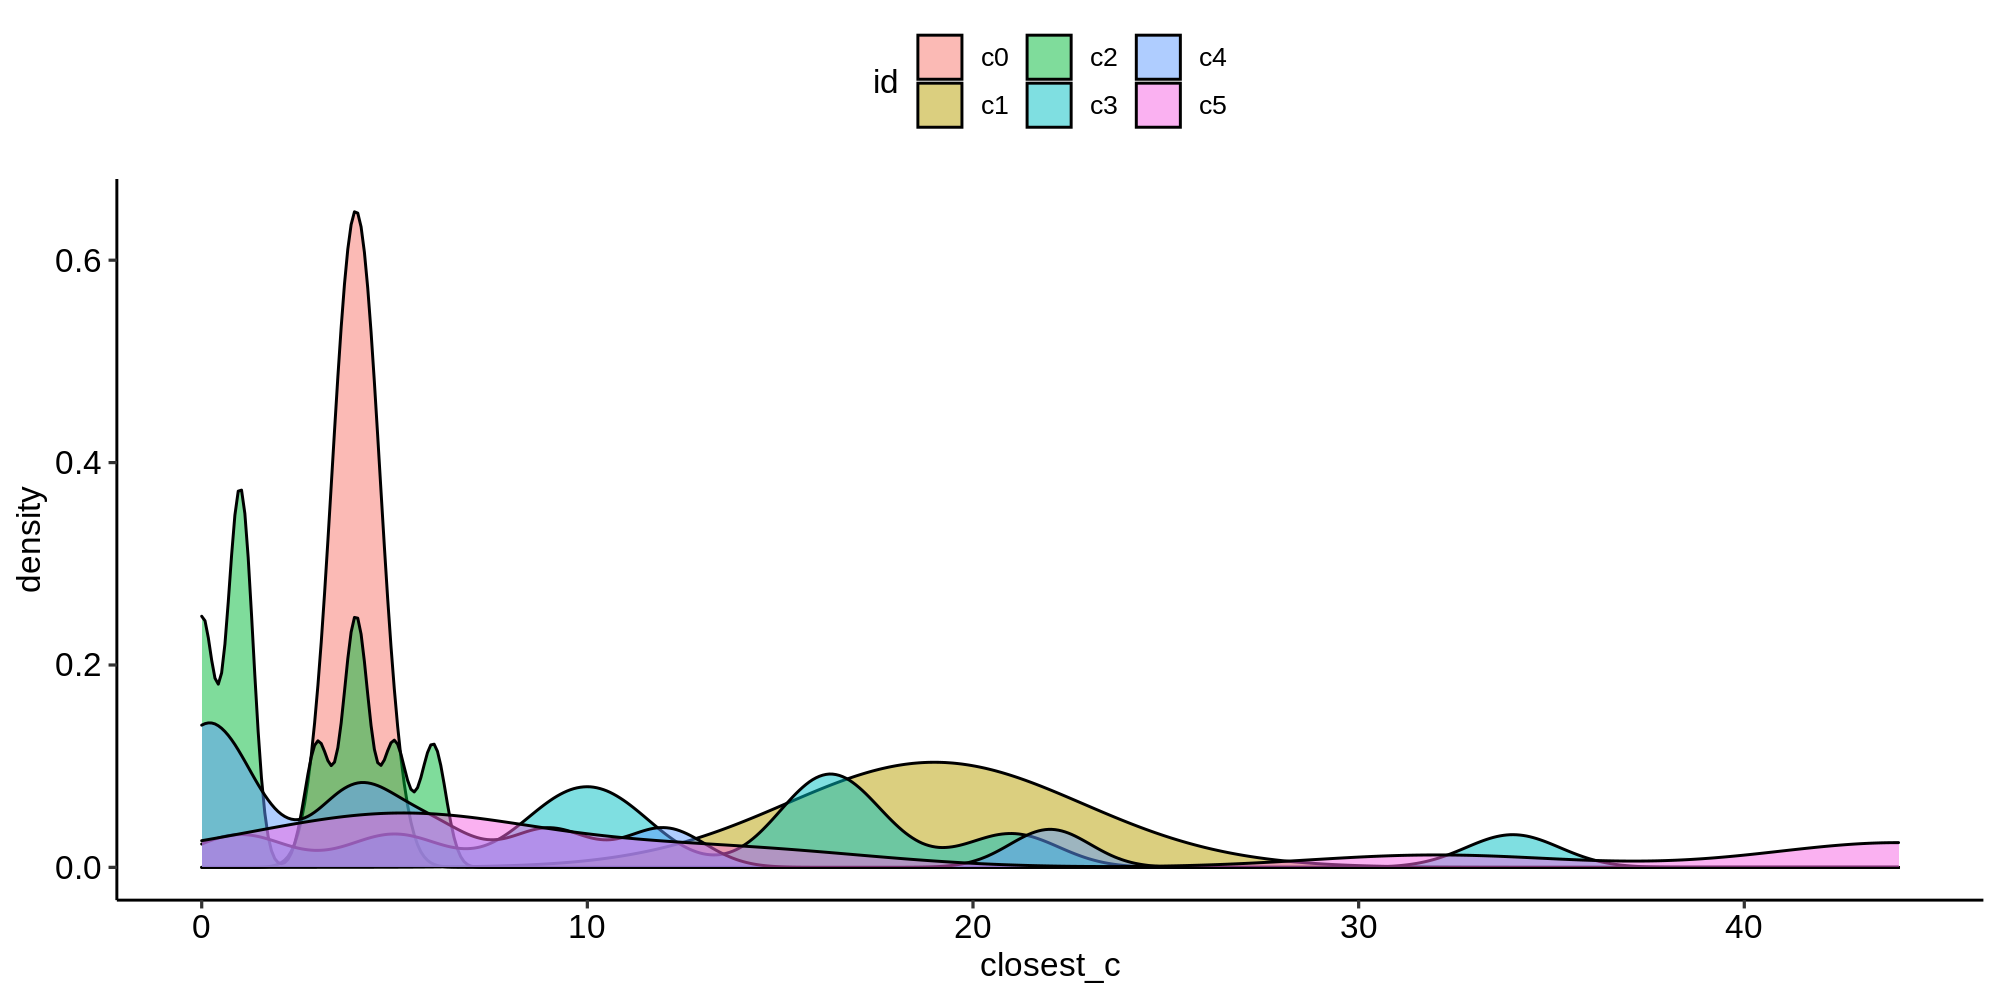

In [92]:
%%R -i closest_c_df -w 10 -h 5 --units in -r 200

ggplot(closest_c_df, aes(x=closest_c, fill=id)) + geom_density(alpha=0.5) + theme_pubr()